# Preparações

## Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.framework.ops import disable_eager_execution

from keras.layers import Conv1D, Conv1DTranspose, Lambda, Reshape, GlobalAveragePooling1D
from keras.models import Model, save_model

from keras.callbacks import EarlyStopping
import keras.backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pickle

import warnings
warnings.filterwarnings("ignore")

## Definição do processamento dos dados

In [2]:
# month = 'april'  # Usa dados até Abril para treinar o modelo; E a partir de Maio para testar o modelo

class DataPreprocessor:
    def __init__(self, data_path, month=None):
        self.data_path = data_path
        self.df = pd.read_csv(self.data_path)
        self.df = self.df.drop(self.df.columns[0], axis=1)
        self.df['timestamp'] = pd.to_datetime(self.df['timestamp'])
        self.train_data = None
        self.test_data = None
        self.analog_train = None
        self.analog_test = None
        self.digital_train = None
        self.digital_test = None
        self.month = month

    def preprocessing_df(self):
        # Criar coluna que indica a dados anomalos, bem os dados de 1 dia antes como anomailas
        # Dados saudaveis : 0
        # Dados anomalos: 1
        self.df['is_anomaly'] = np.where(
            ((self.df['timestamp'] >= "2020-04-11 11:50:00") & (self.df['timestamp'] <= "2020-04-12 23:30:00")) |
            ((self.df['timestamp'] >= "2020-04-17 00:00:00") & (self.df['timestamp'] <= "2020-04-19 01:30:00")) |
            ((self.df['timestamp'] >= "2020-04-28 03:20:00") & (self.df['timestamp'] <= "2020-04-29 22:20:00")) |
            
            ((self.df['timestamp'] >= "2020-05-12 14:00:00") & (self.df['timestamp'] <= "2020-05-13 23:59:00")) |
            ((self.df['timestamp'] >= "2020-05-17 05:00:00") & (self.df['timestamp'] <= "2020-05-20 20:00:00")) |
            
            ((self.df['timestamp'] >= "2020-05-28 23:30:00") & (self.df['timestamp'] <= "2020-05-30 06:00:00")) |
            
            ((self.df['timestamp'] >= "2020-05-31 15:00:00") & (self.df['timestamp'] <= "2020-06-01 15:40:00")) |
            ((self.df['timestamp'] >= "2020-06-02 10:00:00") & (self.df['timestamp'] <= "2020-06-03 11:00:00")) |
            ((self.df['timestamp'] >= "2020-06-04 10:00:00") & (self.df['timestamp'] <= "2020-06-07 14:30:00")) |
            
            ((self.df['timestamp'] >= "2020-07-07 17:30:00") & (self.df['timestamp'] <= "2020-07-08 19:00:00")) |
            ((self.df['timestamp'] >= "2020-07-14 14:30:00") & (self.df['timestamp'] <= "2020-07-15 19:00:00")) |
            ((self.df['timestamp'] >= "2020-07-16 04:30:00") & (self.df['timestamp'] <= "2020-07-17 05:30:00"))
            , 1, 0)
        self.data_path = "dataset_train_processed.csv"
        self.df.to_csv(self.data_path)
        self.df = pd.read_csv(self.data_path)

    def preprocessing_autoencoder(self):
        # Define periodo de treino e teste
        # Para o treino são somente considerados os dados "saudáveis" que não contenham anomalias
        if self.month == 'april':
            self.train_data = self.df[(self.df['timestamp'] >= "2020-02-01 00:00:00") & (self.df['timestamp'] < "2020-04-30 11:59:59") & (self.df['is_anomaly'] == 0)]
            self.test_data = self.df[(self.df['timestamp'] >= "2020-05-01 00:00:00") & (self.df['timestamp'] < "2020-07-31 11:59:59")]
        elif self.month == 'may':
            self.train_data = self.df[(self.df['timestamp'] >= "2020-02-01 00:00:00") & (self.df['timestamp'] < "2020-05-31 11:59:59") & (self.df['is_anomaly'] == 0)]
            self.test_data = self.df[(self.df['timestamp'] >= "2020-06-01 00:00:00") & (self.df['timestamp'] < "2020-07-31 11:59:59")]
        elif self.month == 'june':
            self.train_data = self.df[(self.df['timestamp'] >= "2020-02-01 00:00:00") & (self.df['timestamp'] < "2020-06-30 11:59:59") & (self.df['is_anomaly'] == 0)]
            self.test_data = self.df[(self.df['timestamp'] >= "2020-07-01 00:00:00") & (self.df['timestamp'] < "2020-07-31 11:59:59")]
        else:
            self.train_data = self.df[(self.df['timestamp'] >= "2020-02-01 00:00:00") & (self.df['timestamp'] < "2020-07-31 11:49:59") & (self.df['is_anomaly'] == 0)]
            self.test_data = self.df[(self.df['timestamp'] >= "2020-04-11 11:50:00") & (self.df['timestamp'] < "2020-07-31 11:59:59")]
        
        # Deletar coluna não necessária
        self.train_data.drop(self.train_data.columns[0], axis=1,inplace=True)
        self.test_data.drop(self.test_data.columns[0], axis=1, inplace=True)

        # Padronizar dados analógicos e mantém dados digitais
        scaler = StandardScaler()
        self.analog_train = pd.DataFrame(scaler.fit_transform(self.train_data.iloc[:, 1:8]))
        self.digital_train = self.train_data.iloc[:, 8:16]
        self.analog_test = pd.DataFrame(scaler.transform(self.test_data.iloc[:, 1:8]))
        self.digital_test = self.test_data.iloc[:, 8:16]


In [3]:
disable_eager_execution() # VAE precisa desse passo para funcionar
np.set_printoptions(suppress=True, precision=10) # Suprime notação científica

## Definição dos modelos

In [4]:
class AutoencoderModels:

    def __init__(self, kind_of_model, kind_of_data, analog_train, analog_test, digital_train, digital_test):
        self.kind_of_data = kind_of_data
        self.kind_of_model = kind_of_model
        self.model = None
        self.hist = None
        self.epochs = 50

        if self.kind_of_data == "analog":
            self.shape_param = 7
            self.train_data = analog_train
            self.test_data = analog_test
        elif self.kind_of_data == "digital":
            self.shape_param = 8
            self.train_data = digital_train
            self.test_data = digital_test


    def leaky_relu(self, x):  # Função de ativação da camada de saída para modelos analógicos, reduz o loss value
        return tf.nn.leaky_relu(x, alpha=0.01)


    def build_autoencoder(self):
        def sampling(args):
                z_mean, z_log_var = args
                batch_size = K.shape(z_mean)[0]
                dim = K.int_shape(z_mean)[1]
                epsilon = K.random_normal(shape=(batch_size, dim))
                return z_mean + K.exp(0.5 * z_log_var) * epsilon

        def vae_loss(x_actual, x_decoded):
            reconstruction_loss = K.mean(K.square(x_actual - x_decoded)) # Mede quão bem o VAE reconstrói com acurácia os dados de entrada
            kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) # Calcula a diferença entre a distribuição latetne aprendida e a distribuição dos dados
            return reconstruction_loss + kl_loss
        
        # Definindo a estrutura do modelo de autoencoder
        # Camada de Input
        input_layer = tf.keras.Input(shape=(1, self.train_data.shape[1])) # Formato da entrada é: nº de timesteps = 1, nº de features = nº de colunas do dataset
        # Camadas do Encoder > Convolucionais para extrair características dos dados de entrada
        hidden_1 = Conv1D(filters=32, padding="same", kernel_size=3, activation='relu')(input_layer)
        hidden_2 = Conv1D(filters=16, padding="same", kernel_size=3, activation='relu')(hidden_1)
        # Camada de bottleneck ou camada latente > Essa camada é uma representação com menos dimensões dos dados de entrada aprendidos com o método de amostragem
        z_mean = Conv1D(filters=6, padding="same", kernel_size=3, activation="linear")(hidden_2)
        z_log_var = Conv1D(filters=6, padding="same", kernel_size=3, activation="linear")(hidden_2)
        bottleneck_vae_analog =  Lambda(sampling)([z_mean, z_log_var])
        bottleneck_vae_digital = Lambda(sampling)([z_mean, z_log_var])
        bottleneck_sae_analog = Conv1D(filters=6, padding="same", kernel_size=3, activation="relu", activity_regularizer=tf.keras.regularizers.l1_l2(l1=0.005, l2=0.1))(hidden_2)
        bottleneck_sae_digital = Conv1D(filters=6, padding="same", kernel_size=3, activation="relu")(hidden_2)
        bottleneck = locals()[f'bottleneck_{self.kind_of_model}_{self.kind_of_data}']
        # Camadas do Decoder > Convolucionais transpostas para reconstruir os dados de entrada
        hidden_3 = Conv1DTranspose(filters=16, padding="same", kernel_size=3, activation='relu')(bottleneck)
        hidden_4 = Conv1DTranspose(filters=32, padding="same", kernel_size=3, activation='relu')(hidden_3)
        # Camada de saída
        output_layer_vae_analog = Reshape((1, self.train_data.shape[1]))(GlobalAveragePooling1D()(Conv1DTranspose(filters=self.train_data.shape[1], padding="same", kernel_size=3, activation=self.leaky_relu)(hidden_4)))
        output_layer_vae_digital = Reshape((1, self.train_data.shape[1]))(GlobalAveragePooling1D()(Conv1D(filters=self.train_data.shape[1], padding="same", kernel_size=3, activation="sigmoid")(hidden_4)))
        output_layer_sae_analog = Conv1DTranspose(filters=self.train_data.shape[1], padding="same", kernel_size=3, activation=self.leaky_relu)(hidden_4) 
        output_layer_sae_digital = Conv1DTranspose(filters=self.train_data.shape[1], padding="same", kernel_size=3, activation="sigmoid")(hidden_4) 
        output_layer = locals()[f'output_layer_{self.kind_of_model}_{self.kind_of_data}']

        # Criação do modelo
        loss_vae_analog = vae_loss
        loss_vae_digital = vae_loss
        loss_sae_analog = 'mse'
        loss_sae_digital = 'binary_crossentropy'
        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer='adam', loss=locals()[f'loss_{self.kind_of_model}_{self.kind_of_data}'])
        callback = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
        hist = model.fit(np.expand_dims(self.train_data, 1), np.expand_dims(self.train_data, 1), validation_split=0.2, epochs=self.epochs, callbacks=[callback], batch_size=60, verbose=0)
        save_model(model, f'{self.kind_of_model}_{self.kind_of_data}.h5')
        self.model = model
        self.hist = hist


    def autoencoder_predict(self):
        train_pred = self.model.predict(np.expand_dims(self.train_data, 1))
        print("Shape of train_pred before reshaping:", train_pred.shape)
        train_pred = np.reshape(train_pred, (len(train_pred), self.shape_param))
        test_pred = self.model.predict(np.expand_dims(self.test_data, 1))
        print("Shape of test_pred before reshaping:", test_pred.shape)
        test_pred = np.reshape(test_pred, (len(test_pred), self.shape_param))
        return train_pred, test_pred


    def plot_losses(self):
        plt.plot(self.hist.history["loss"])
        plt.plot(self.hist.history["val_loss"])
        plt.title("Training/Validation Loss")
        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.legend(["training_loss", "validation_loss"])
        plt.show()

## Definição da avaliação dos resultados

In [5]:
class AutoencoderResults:
    def __init__(self, kind_of_model, kind_of_data, alpha, threshold, train_data, test_data, analog_train, analog_test, digital_train, digital_test):
        self.kind_of_model = kind_of_model
        self.kind_of_data = kind_of_data
        self.train_data = train_data
        self.test_data = test_data
        self.analog_train = analog_train
        self.analog_test = analog_test
        self.digital_train = digital_train
        self.digital_test = digital_test
        self.test_pred = None
        self.threshold = threshold
        self.alpha = alpha
        
        
    def compute_error(self):
        with open(f"{self.kind_of_model}_{self.kind_of_data}_test_pred", "rb") as file:
            self.test_pred = pickle.load(file)

        # 1º Calcula o MSE (mean square error) entre os dados de teste e as previsões do modelo
        # 2º Aplica o filtro passa-baixa para suavizar os erros
        # 3º Verifica se o erro é maior do que o limite definido para classificar como anomalia (1) ou normal (0)
        if self.kind_of_model == "sae" and self.kind_of_data == "analog":
            test_error = np.mean(np.square(self.test_pred - self.analog_test), axis=1)
            filtered_error = self.low_pass_filter(test_error, alpha=self.alpha)
            predictions = [1 if error > self.threshold else 0 for error in filtered_error]
        elif self.kind_of_model == "vae" and self.kind_of_data == "analog":
            test_error = np.mean(np.square(self.test_pred - self.analog_test), axis=1)
            filtered_error = self.low_pass_filter(test_error, alpha=self.alpha)
            predictions = [1 if error > self.threshold else 0 for error in filtered_error]
        elif self.kind_of_model == "sae" and self.kind_of_data == "digital":
            test_error = np.mean(np.square(self.test_pred - self.digital_test), axis=1)
            filtered_error = self.low_pass_filter(test_error, alpha=self.alpha)
            predictions = [1 if error > 0.1 else 0 for error in filtered_error]
        elif self.kind_of_model == "vae" and self.kind_of_data == "digital":
            test_error = np.mean(np.square(self.test_pred - self.digital_test), axis=1)
            filtered_error = self.low_pass_filter(test_error, alpha=self.alpha)
            predictions = [1 if error > self.threshold else 0 for error in filtered_error]
        
        self.test_data["predicted_output"] = predictions
        print(f"!!!!!!!!!!!!!!!!!!!! Threshold for {self.kind_of_model} {self.kind_of_data} model: {self.threshold} !!!!!!!!!!!!!!!!!!!!!")

    
    def low_pass_filter(self, error, alpha): # test_error é passadp pelo low_pass_filter para melhorar a avaliação das métricas
        error = error.reset_index(drop = True)
        output = [error[0]]  # Inicia a saída com o primeiro valor de entrada
        for i in range(1, len(error)):
            output.append(output[i - 1] + alpha * (error[i] - output[i - 1]))
        return output


    def create_sequence(self, anomalies):  # Verificar se pontos anomalos são continuos ou não, se não forem, descarta-los por alta chance de serem ruido
        tmp1 = []
        tmp2 = []
        lst = []
        for i in range(len(anomalies)):
            if anomalies[i] == 1:
                tmp1.append(i)
        for j in range(len(tmp1) - 1):
            if tmp1[j] + 1 == tmp1[j + 1]:  # Verificar se o próximo índice é igual ao anterior + 1
                tmp2.append(tmp1[j])
            if tmp1[j + 1] != tmp1[j] + 1:
                if len(tmp2) >= 2:  # Sequências devem ser X segundos ou mais - afeta Precisão e Recall
                    tmp2.append(tmp1[j])
                    lst.extend(tmp2)
                tmp2 = []
        return lst


    def plot_cm(self):
        cm = confusion_matrix(self.test_data["is_anomaly"], self.test_data["predicted_output"])
        tp = cm[1, 1]
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        print(classification_report(self.test_data["is_anomaly"], self.test_data["predicted_output"]))
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1_score = 2 * (precision * recall) / (precision + recall)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
        disp.plot(values_format='d', cmap="Reds")
        
        plt.title(f"{self.kind_of_model.upper()} - {self.kind_of_data.capitalize()} (alpha={self.alpha})\nPrecision={precision:.2f}, Recall={recall:.2f}, F1 Score={f1_score:.2f}")
            
        plt.show()

## Definição da chamada das classes e funções para treino, teste e avaliação

In [6]:
def train_test_model(kind_of_model, kind_of_data, alpha, threshold): # kind_of_model = "sae" or "vae"; kind_of_data = "analog" or "digital"
    
    # Cria o modelo de autoencoder
    autoencoder = AutoencoderModels(kind_of_model, kind_of_data, preprocessor.analog_train, preprocessor.analog_test, preprocessor.digital_train, preprocessor.digital_test)

    # Faz o treinamento do modelo
    autoencoder.build_autoencoder()

    # Faz as previsões para os dados de treino e teste
    train_pred, test_pred = autoencoder.autoencoder_predict()
    
    with open(f"{kind_of_model}_{kind_of_data}_train_pred", "wb") as file:
            pickle.dump(train_pred, file)
    with open(f"{kind_of_model}_{kind_of_data}_test_pred" , "wb") as file:
            pickle.dump(test_pred, file)
            
    print(autoencoder.model.summary())
    autoencoder.plot_losses()
    
    # Calcula o erro e plota a matriz de confusão
    autoencoder_results = AutoencoderResults(kind_of_model, kind_of_data, alpha, threshold, preprocessor.train_data, preprocessor.test_data, preprocessor.analog_train, preprocessor.analog_test, preprocessor.digital_train, preprocessor.digital_test)
    autoencoder_results.compute_error()
    autoencoder_results.plot_cm()

# Treinos e avaliações dos modelos

## Preparação geral dos dados

In [7]:
preprocessor = DataPreprocessor("MetroPT3AirCompressor.csv")
preprocessor.preprocessing_df()

## Primeira análise

#### Comparação entre modelos SAE e VAE para dados analógicos e digitais

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 conv1d (Conv1D)             (None, 1, 32)             800       
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 16)             1552      
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 6)              294       
                                                                 
 conv1d_transpose (Conv1DTra  (None, 1, 16)            304       
 nspose)                                                         
                                                                 
 conv1d_transpose_1 (

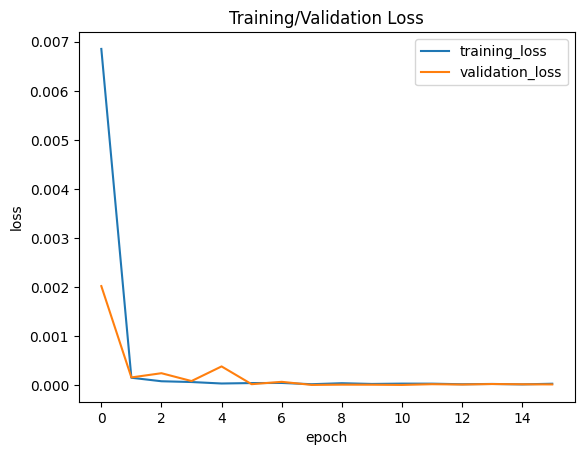

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 7.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



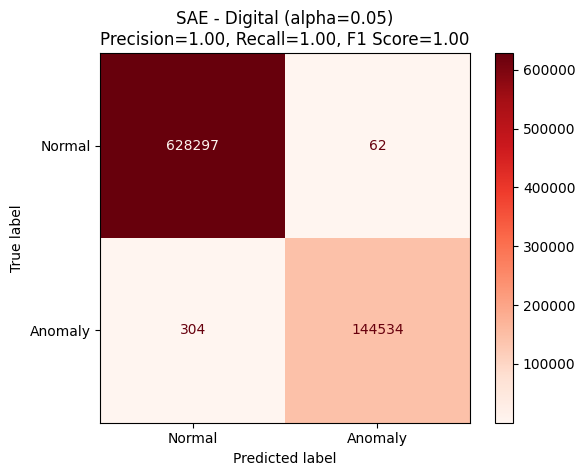

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1, 8)]       0           []                               
                                                                                                  
 conv1d_7 (Conv1D)              (None, 1, 32)        800         ['input_2[0][0]']                
                                                                                                  
 conv1d_8 (Conv1D)              (None, 1, 16)        1552        ['conv1d_7[0][0]']               
                                                                                                  
 conv1d_9 (Conv1D)              (None, 1, 6)         294         ['conv1d_8[0][0]']  

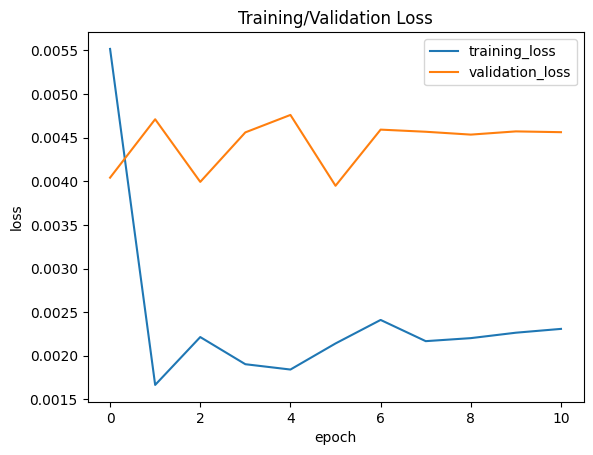

!!!!!!!!!!!!!!!!!!!! Threshold for vae digital model: 0.1 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    628359
           1       0.96      1.00      0.98    144838

    accuracy                           0.99    773197
   macro avg       0.98      0.99      0.99    773197
weighted avg       0.99      0.99      0.99    773197



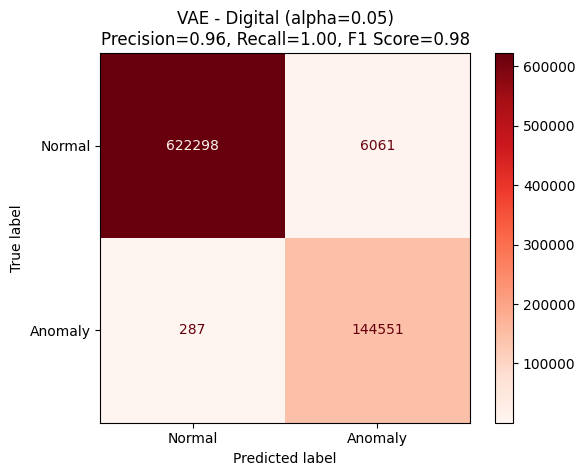

Shape of train_pred before reshaping: (1146728, 1, 7)
Shape of test_pred before reshaping: (773197, 1, 7)
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1, 7)]            0         
                                                                 
 conv1d_14 (Conv1D)          (None, 1, 32)             704       
                                                                 
 conv1d_15 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_18 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_10 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_1

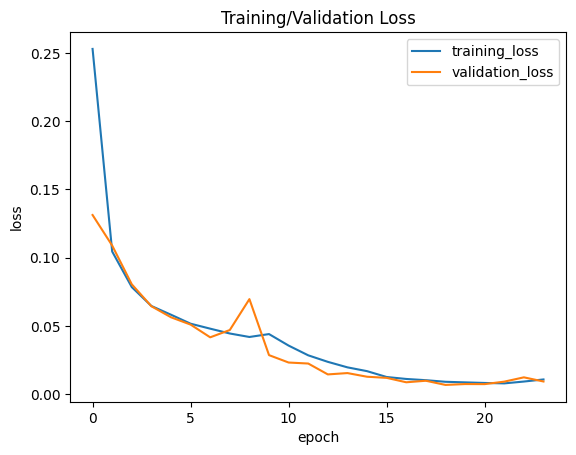

!!!!!!!!!!!!!!!!!!!! Threshold for sae analog model: 0.00188 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       0.88      0.83      0.85    628359
           1       0.39      0.49      0.44    144838

    accuracy                           0.76    773197
   macro avg       0.63      0.66      0.64    773197
weighted avg       0.78      0.76      0.77    773197



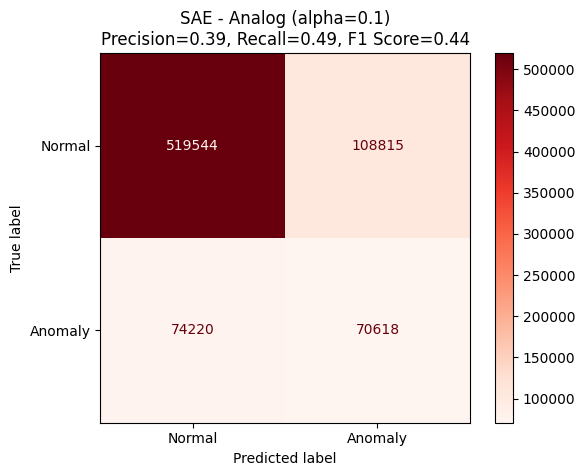

Shape of train_pred before reshaping: (1146728, 1, 7)
Shape of test_pred before reshaping: (773197, 1, 7)
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1, 7)]       0           []                               
                                                                                                  
 conv1d_21 (Conv1D)             (None, 1, 32)        704         ['input_4[0][0]']                
                                                                                                  
 conv1d_22 (Conv1D)             (None, 1, 16)        1552        ['conv1d_21[0][0]']              
                                                                                                  
 conv1d_23 (Conv1D)             (None, 1, 6)         294         ['conv1d_22[0][0]'] 

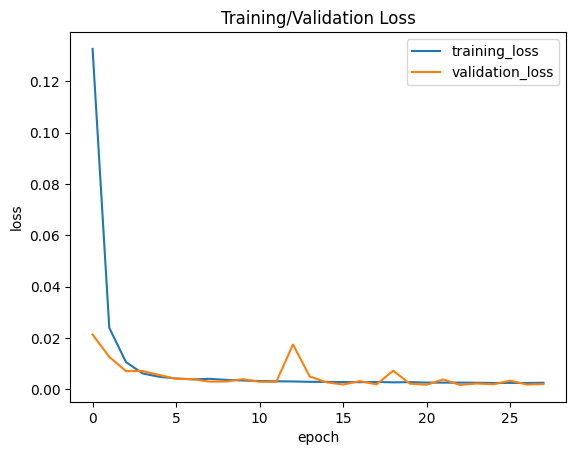

!!!!!!!!!!!!!!!!!!!! Threshold for vae analog model: 0.004 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       0.87      0.91      0.89    628359
           1       0.51      0.40      0.45    144838

    accuracy                           0.82    773197
   macro avg       0.69      0.66      0.67    773197
weighted avg       0.80      0.82      0.81    773197



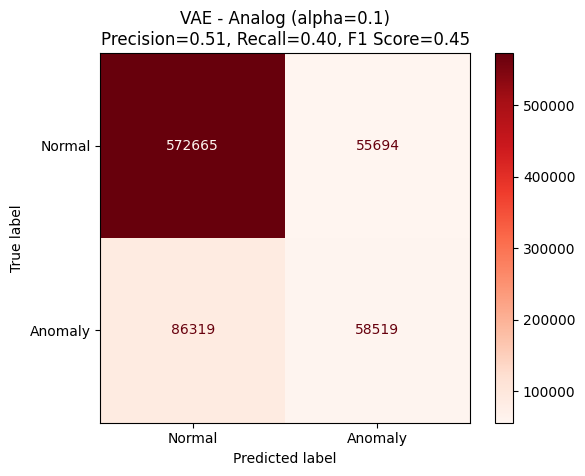

In [8]:
preprocessor = DataPreprocessor("dataset_train_processed.csv", 'abril')
preprocessor.preprocessing_autoencoder()

train_test_model('sae', 'digital', 0.05, 7.5e-65) # SAE Digital
train_test_model('vae', 'digital', 0.05, 0.1) # VAE Digital
train_test_model('sae', 'analog', 0.1, 0.00188) # SAE Analog
train_test_model('vae', 'analog', 0.1, 0.004) # VAE Analog

## Segunda análise

#### Otimização de alpha e threshold

### Variação de alpha

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 conv1d_28 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_29 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_33 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_20 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_2

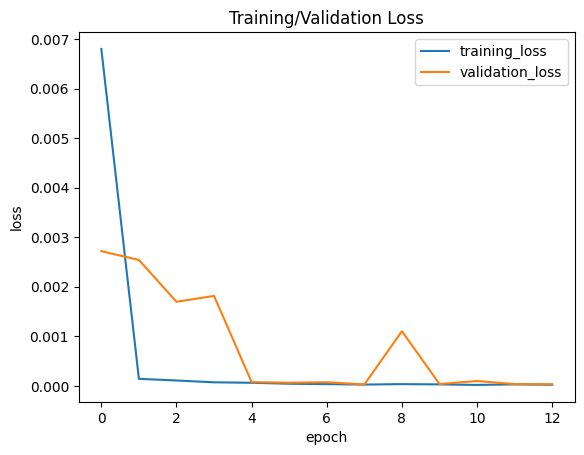

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 7.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



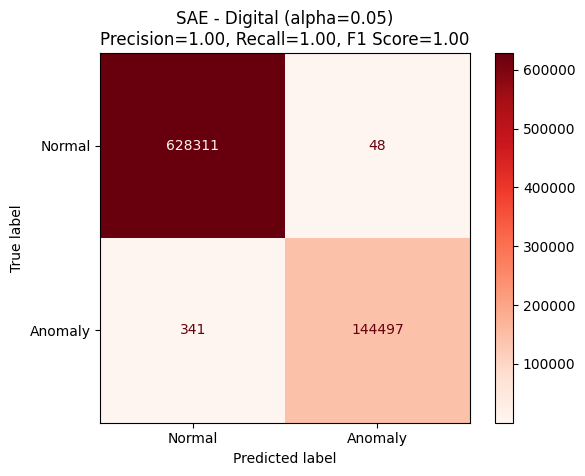

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 conv1d_35 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_36 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_40 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_25 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_2

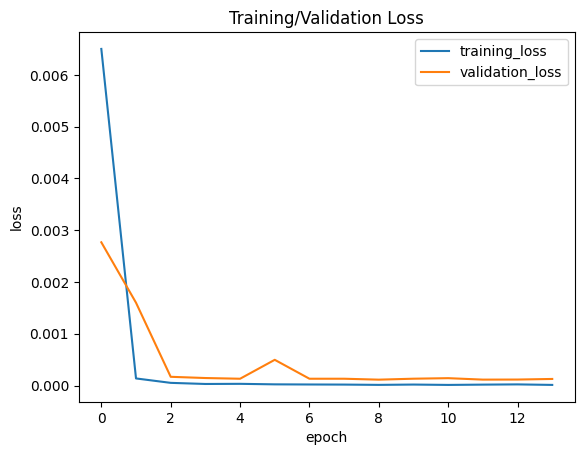

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 7.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



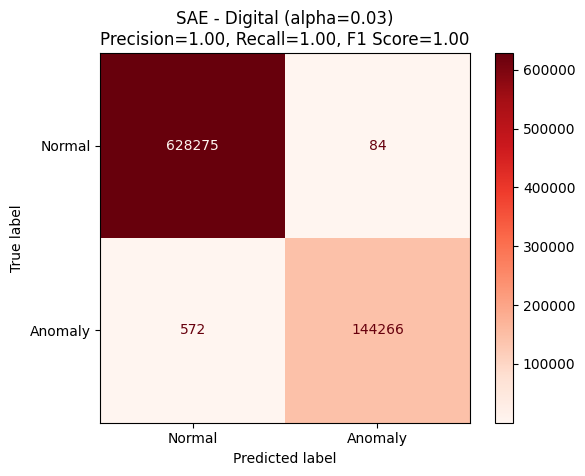

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 conv1d_42 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_43 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_47 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_30 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_3

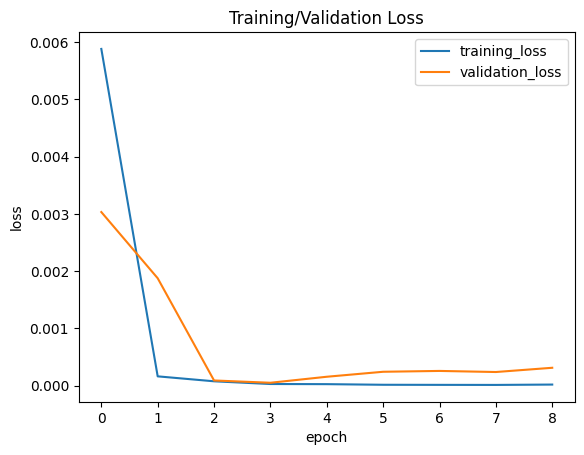

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 7.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



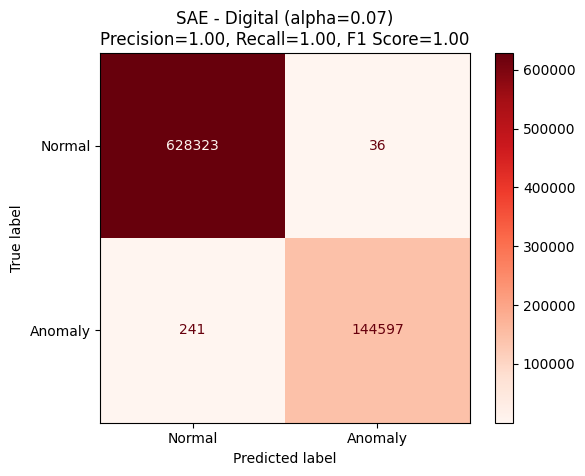

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 conv1d_49 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_50 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_54 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_35 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_3

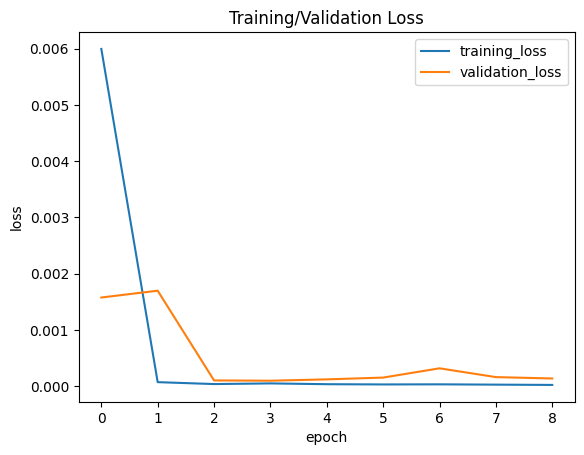

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 7.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



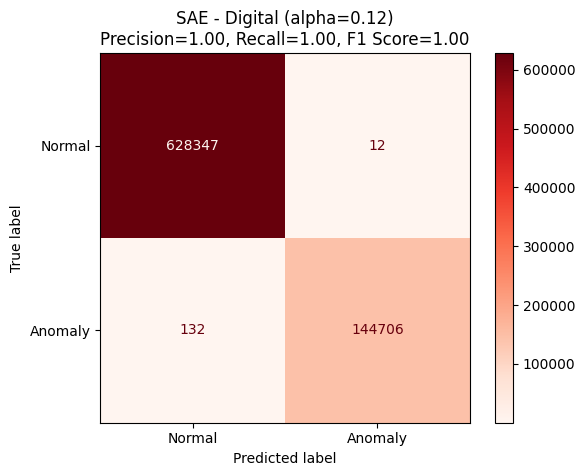

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 1, 8)]            0         
                                                                 
 conv1d_56 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_57 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_61 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_40 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_4

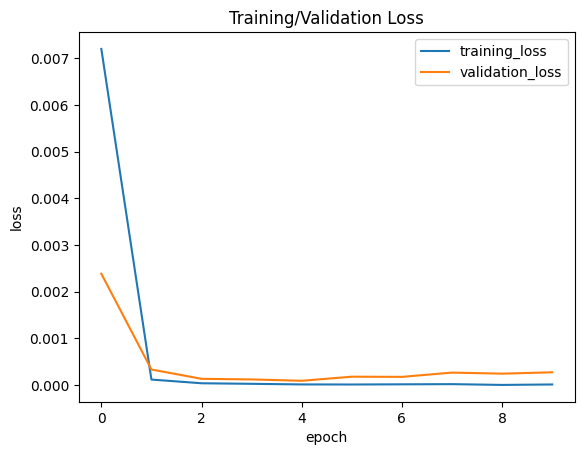

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 7.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



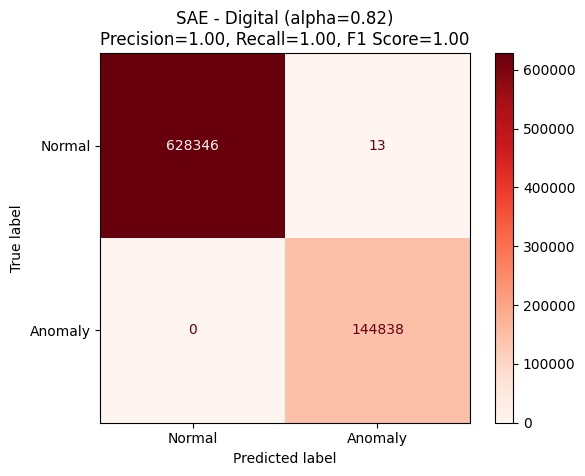

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_63 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_64 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_68 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_45 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_4

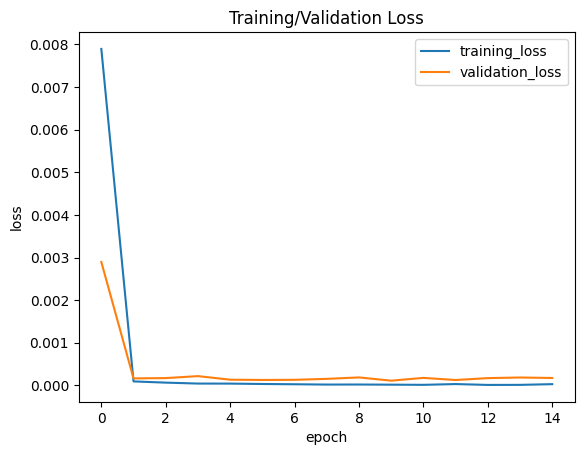

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 7.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



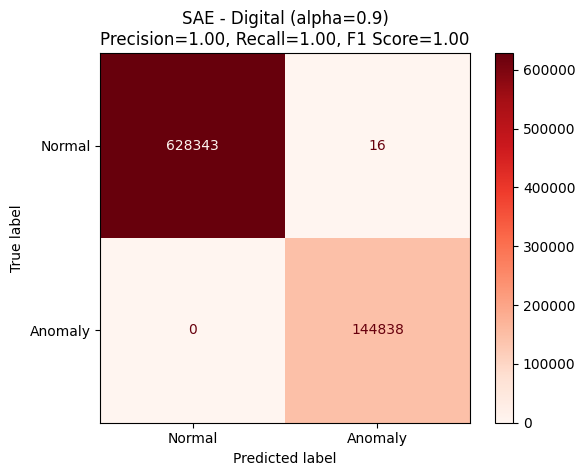

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_70 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_71 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_75 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_50 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_

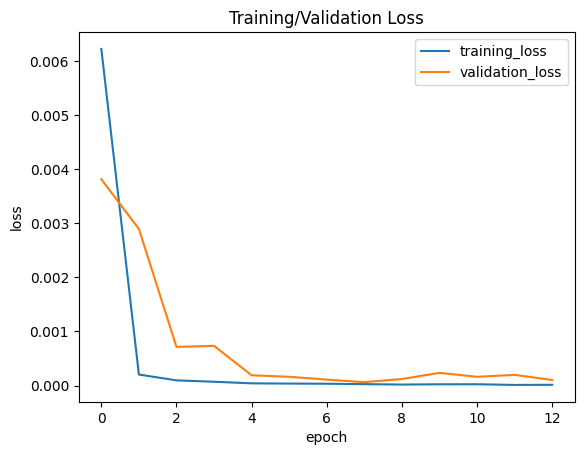

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 7.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



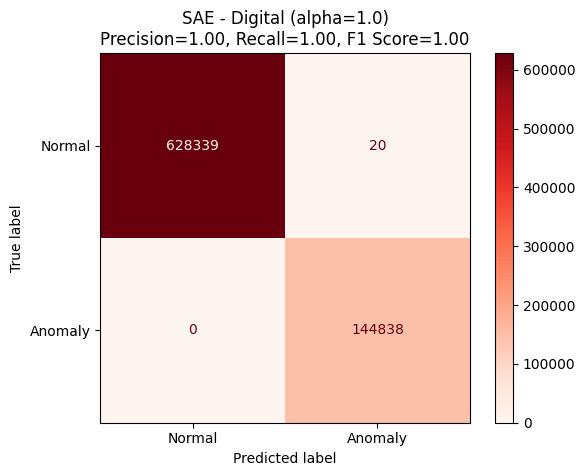

In [9]:
preprocessor = DataPreprocessor("dataset_train_processed.csv", 'abril')
preprocessor.preprocessing_autoencoder()
 
train_test_model('sae', 'digital', alpha=0.05, threshold=7.5e-65) # alpha = 0.05
train_test_model('sae', 'digital', alpha=0.03, threshold=7.5e-65) # alpha = 0.03
train_test_model('sae', 'digital', alpha=0.07, threshold=7.5e-65) # alpha = 0.07
train_test_model('sae', 'digital', alpha=0.12, threshold=7.5e-65) # alpha = 0.12
train_test_model('sae', 'digital', alpha=0.82, threshold=7.5e-65) # alpha = 0.82
train_test_model('sae', 'digital', alpha=0.90, threshold=7.5e-65) # alpha = 0.90
train_test_model('sae', 'digital', alpha=1.00, threshold=7.5e-65) # alpha = 1.00

### Variação de threshold

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_77 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_78 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_82 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_55 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_

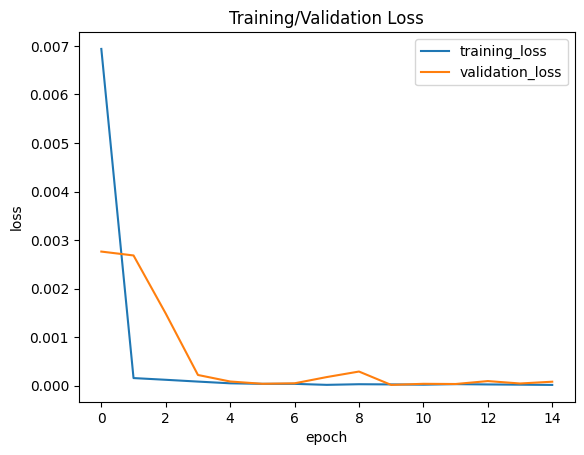

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 1.5e-64 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



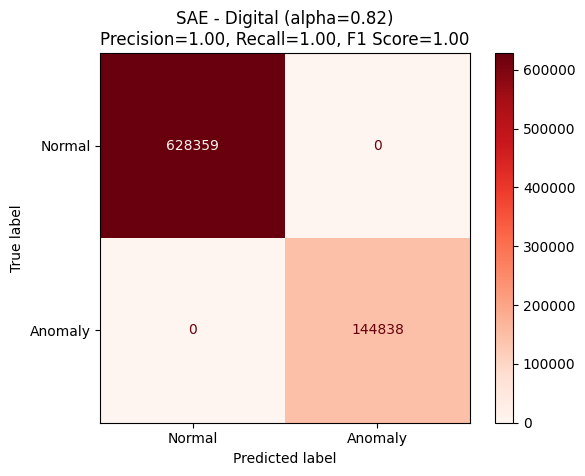

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_84 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_85 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_89 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_60 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_

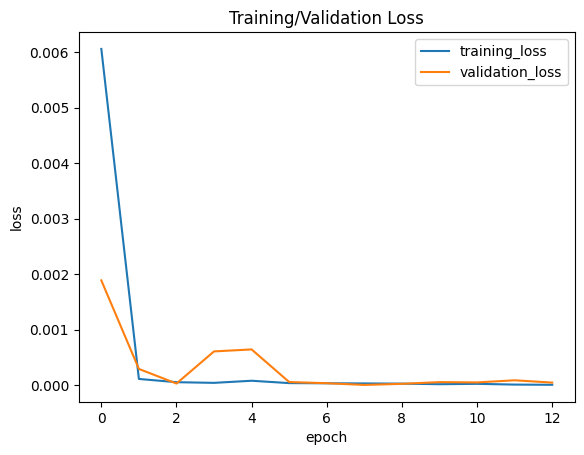

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 3.75e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



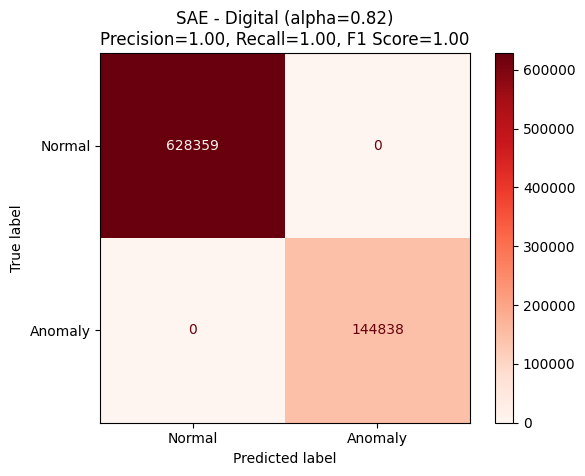

Shape of train_pred before reshaping: (1146728, 1, 8)
Shape of test_pred before reshaping: (773197, 1, 8)
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_91 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_92 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_96 (Conv1D)          (None, 1, 6)              294       
                                                                 
 conv1d_transpose_65 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_

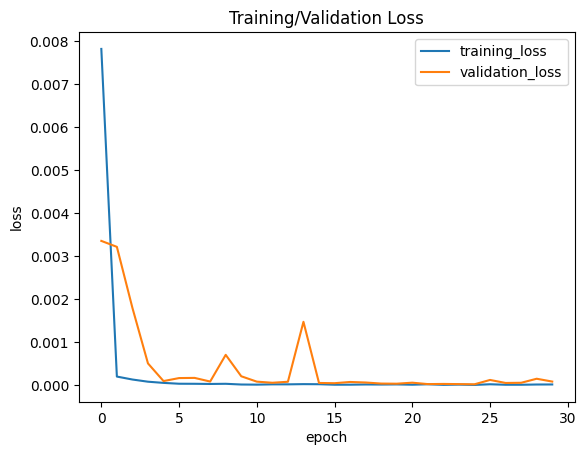

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 1.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    628359
           1       1.00      1.00      1.00    144838

    accuracy                           1.00    773197
   macro avg       1.00      1.00      1.00    773197
weighted avg       1.00      1.00      1.00    773197



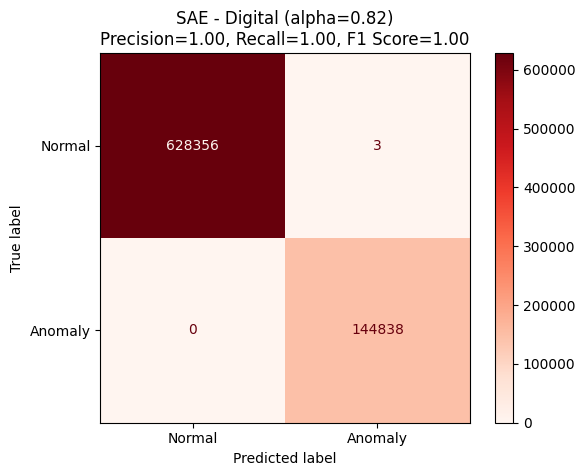

In [10]:
preprocessor = DataPreprocessor("dataset_train_processed.csv", 'abril')
preprocessor.preprocessing_autoencoder()

train_test_model('sae', 'digital', alpha=0.82, threshold=15.00e-65) # threshold = 15e-65
train_test_model('sae', 'digital', alpha=0.82, threshold=03.75e-65) # threshold = 3.75e-65
train_test_model('sae', 'digital', alpha=0.82, threshold=01.50e-65) # threshold = 1.5e-65

## Terceira análise

#### Variação dos dados de treino/teste

Shape of train_pred before reshaping: (603299, 1, 8)
Shape of test_pred before reshaping: (647594, 1, 8)
Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_98 (Conv1D)          (None, 1, 32)             800       
                                                                 
 conv1d_99 (Conv1D)          (None, 1, 16)             1552      
                                                                 
 conv1d_103 (Conv1D)         (None, 1, 6)              294       
                                                                 
 conv1d_transpose_70 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_7

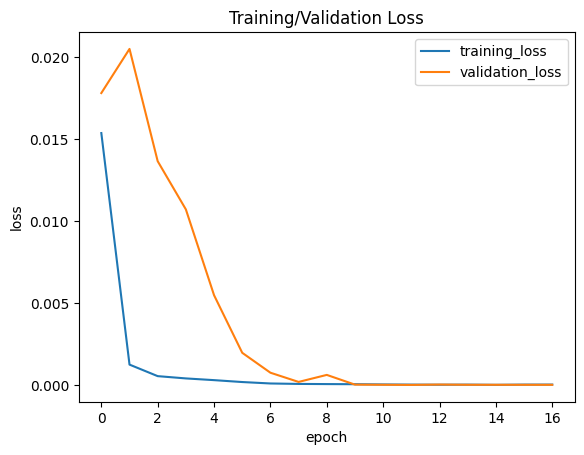

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 1.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    543011
           1       1.00      1.00      1.00    104583

    accuracy                           1.00    647594
   macro avg       1.00      1.00      1.00    647594
weighted avg       1.00      1.00      1.00    647594



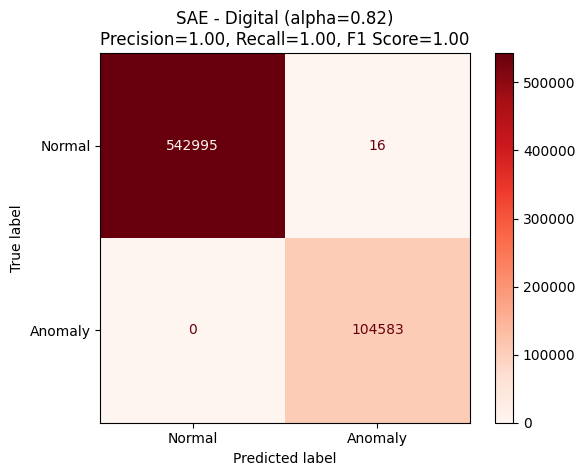

In [11]:
preprocessor = DataPreprocessor("dataset_train_processed.csv", 'april')
preprocessor.preprocessing_autoencoder()

train_test_model('sae', 'digital', alpha=0.82, threshold=1.5e-65)

Shape of train_pred before reshaping: (764724, 1, 8)
Shape of test_pred before reshaping: (434794, 1, 8)
Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_105 (Conv1D)         (None, 1, 32)             800       
                                                                 
 conv1d_106 (Conv1D)         (None, 1, 16)             1552      
                                                                 
 conv1d_110 (Conv1D)         (None, 1, 6)              294       
                                                                 
 conv1d_transpose_75 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_7

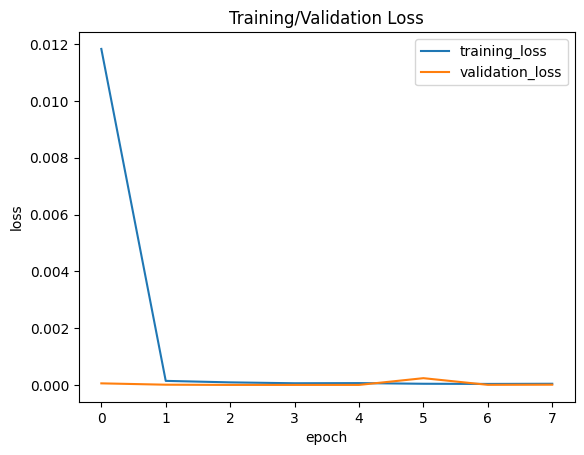

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 1.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    380974
           1       1.00      1.00      1.00     53820

    accuracy                           1.00    434794
   macro avg       1.00      1.00      1.00    434794
weighted avg       1.00      1.00      1.00    434794



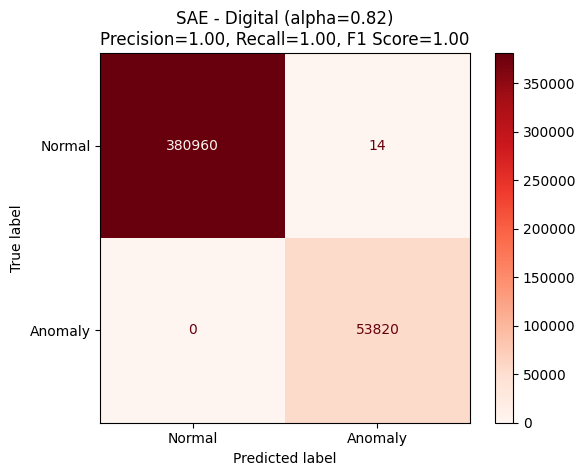

In [12]:
preprocessor = DataPreprocessor("dataset_train_processed.csv", 'may')
preprocessor.preprocessing_autoencoder()

train_test_model('sae', 'digital', alpha=0.82, threshold=1.5e-65)

Shape of train_pred before reshaping: (940912, 1, 8)
Shape of test_pred before reshaping: (218280, 1, 8)
Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 1, 8)]            0         
                                                                 
 conv1d_112 (Conv1D)         (None, 1, 32)             800       
                                                                 
 conv1d_113 (Conv1D)         (None, 1, 16)             1552      
                                                                 
 conv1d_117 (Conv1D)         (None, 1, 6)              294       
                                                                 
 conv1d_transpose_80 (Conv1D  (None, 1, 16)            304       
 Transpose)                                                      
                                                                 
 conv1d_transpose_8

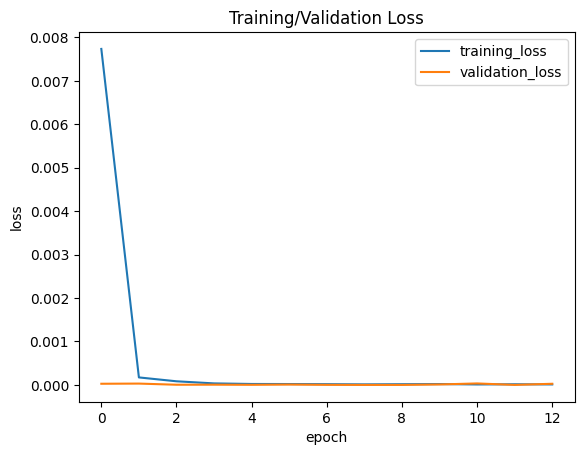

!!!!!!!!!!!!!!!!!!!! Threshold for sae digital model: 1.5e-65 !!!!!!!!!!!!!!!!!!!!!
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    201518
           1       1.00      1.00      1.00     16762

    accuracy                           1.00    218280
   macro avg       1.00      1.00      1.00    218280
weighted avg       1.00      1.00      1.00    218280



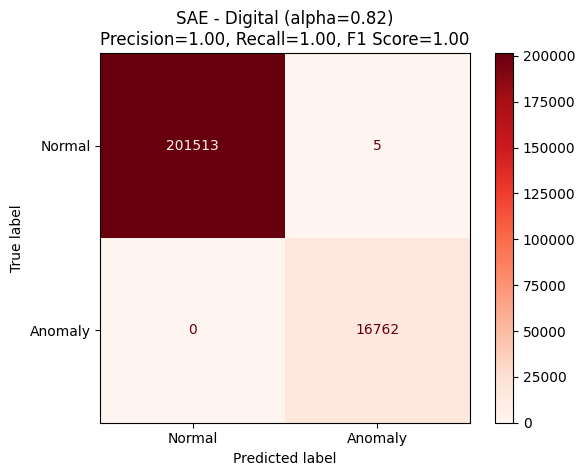

In [13]:
preprocessor = DataPreprocessor("dataset_train_processed.csv", 'june')
preprocessor.preprocessing_autoencoder()

train_test_model('sae', 'digital', alpha=0.82, threshold=1.5e-65)